In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chisquare

## Individual mutation statistics

In [5]:
first_order = pd.read_csv("output/01.mutation_and_comutation_data/first_order_statistics.csv", index_col = 0)
print(len(first_order))

4743


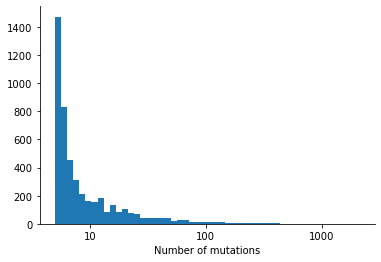

In [6]:
fig=plt.figure()
ax=fig.gca()
ax.hist(np.log10(first_order.n_mutations), bins=50)
ax.set_xlabel("Number of mutations")
ax.set_xticks([1,2,3])
ax.set_xticklabels([10, 100, 1000])
sns.despine()


/tmp/ipykernel_24641/1130403591.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 1, 10, 100, 1000, 10000])


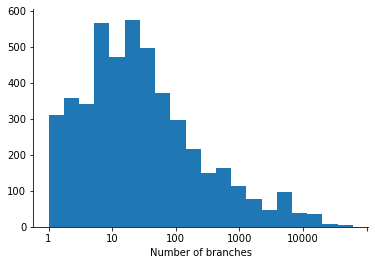

In [7]:
fig=plt.figure()
ax=fig.gca()
first_order["log_n_branches"] = [np.log10(x) if x > 0 else 0 for x in first_order.n_branches_with]
ax.hist(first_order.log_n_branches, bins=20)
ax.set_xlabel("Number of branches")
ax.set_xticklabels([0, 1, 10, 100, 1000, 10000])
sns.despine()

/tmp/ipykernel_24641/377992423.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 0.1, 1, 10, 100, 1000, 10000])


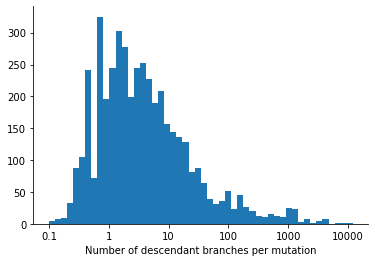

In [8]:
first_order["age_index"] = first_order.n_branches_with

first_order["log10_age_index"] = [np.log10(x) if x >0 else np.nan for x in first_order.age_index]

fig= plt.figure()
ax = fig.gca()
ax.hist(first_order.log10_age_index, bins=50)
ax.set_xticklabels([0, 0.1, 1, 10, 100, 1000, 10000])
ax.set_xlabel("Number of descendant branches per mutation")
sns.despine()

In [9]:
print(np.median(first_order.age_index))

2.4444444444444446


## Median number of lineages per mutation

In [10]:

first_order = pd.read_csv("output/01.mutation_and_comutation_data/first_order_statistics.csv", index_col = 0)
event_freqs = pd.read_csv("output/00.mutation_data_by_lineage/event_frequency_table.csv")
first_order = first_order.merge(event_freqs, left_on="pos", right_on="Position", how="inner")
first_order["L4"] = first_order.L4A + first_order.L4B + first_order.L4C
lineage_columns = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6']


first_order["num_lineages_with_mutation"] = np.sum(first_order[lineage_columns].values > 0,axis=1)
np.median(first_order.num_lineages_with_mutation)

3.0

# Analyses of SNP data

In [11]:
# # Read in the SNP annotation file
snps = pd.read_pickle("input/genotypes_SNP_annotation.pkl")

# Filter for just snps in our analysis
positions = pd.read_csv("output/01.mutation_and_comutation_data/first_order_statistics.csv", index_col=0)
snps = snps.query("pos in @positions.pos")

In [12]:
#percent intergenic
print(len(snps.query("gene_id=='intergenic'"))/len(snps))

0.19460257221168037


# Lineage annotation

In [13]:
# add lineage annotaiton to the results
!mkdir output/03.annotation
# Lineage positions from Freschi et al 2021
lineage_positions = pd.read_csv(
    "input/list_lineage_specific_snps_99_1.txt", header=None)
lineage_positions["position"] = [int(x.split("_")[0]) for x in lineage_positions[0]]

# Lineage positions from Coll et al 2014
coll_positions = pd.read_csv(
    "input/Coll_2014_lineage_barcode.csv",
    index_col=0
)

# Find out which SNPs are in the lineage set
coll_pos = set(coll_positions.position)
lineage_pos = set(lineage_positions.position)
lineage_mutation_indices  = snps.query("pos in @coll_pos or pos in @lineage_pos").index

# Annotate in SNP dataframe
snps["is_lineage"] = False
snps.loc[lineage_mutation_indices, "is_lineage"] = True

snps.to_csv("output/03.annotation/snps_with_gene_annotation.csv")

mkdir: cannot create directory ‘output/03.annotation’: File exists


## Mutations are found in epitope regions

In [14]:
epitopes = pd.read_csv("input/epitope_table_export_1644510184.csv", header=1)
epitopes = epitopes[['Epitope ID','Description', "Starting Position", "Ending Position", 'Antigen Name',
       'Antigen Accession', 'Parent Protein', 'Parent Protein Accession']]

# this table maps the uniprot identifiers to H37Rv locus tags
mapping = pd.read_csv("input/H37Rv_uniprot_proteome_to_locus_ids.csv", index_col=0)

# add the logus tags to the epitope table
epitopes = epitopes.merge(mapping[["Entry", "locus_id"]], left_on="Parent Protein Accession", right_on="Entry", how="inner")
epitopes.to_csv("input/epitope_table_cleaned.csv")
epitopes.head()

,Epitope ID,Description,Starting Position,Ending Position,Antigen Name,Antigen Accession,Parent Protein,Parent Protein Accession,Entry,locus_id
0,19,AAAAKLAGLVFPQPPAPIAV,14.0,33.0,CONSERVED HYPOTHETICAL ALANINE RICH PROTEIN,CAA17970.1,ESX-1 secretion-associated protein EspJ,P9WJC3,P9WJC3,Rv3878
1,250,AAKLAGLVFPQPPAP,16.0,30.0,CONSERVED HYPOTHETICAL ALANINE RICH PROTEIN,CAA17970.1,ESX-1 secretion-associated protein EspJ,P9WJC3,P9WJC3,Rv3878
2,1020,AEKPATEQAEPVHEVTNDDQ,194.0,213.0,hypothetical protein Rv3878 - Mycobacterium tu...,D70803,ESX-1 secretion-associated protein EspJ,P9WJC3,P9WJC3,Rv3878
3,1452,AGARPAASPLAAPVDPSTPA,254.0,273.0,CONSERVED HYPOTHETICAL ALANINE RICH PROTEIN,CAA17970.1,ESX-1 secretion-associated protein EspJ,P9WJC3,P9WJC3,Rv3878
4,7992,DEGAGASPGQQPGGGVPAQA,230.0,249.0,CONSERVED HYPOTHETICAL ALANINE RICH PROTEIN,CAA17970.1,ESX-1 secretion-associated protein EspJ,P9WJC3,P9WJC3,Rv3878


In [15]:
# contains the annotated amino acid change for each SNP
snp_annotation_file = "input/genotypes_SNP_functional_annotation.pkl"
snp_annot = pd.read_pickle(snp_annotation_file)

snps = pd.read_csv("output/03.annotation/snps_with_gene_annotation.csv", index_col=0)

# Ask if the protein itself is an antigen
antigen_protein_names = set(epitopes.locus_id)
snps["in_antigen_protein"] = [x in antigen_protein_names for x in snps.gene_id]

# get the amino acid position for each position in first_order
snps = snps.merge(snp_annot[["pos", "AA_change"]], on="pos", how="left").drop_duplicates(subset=["pos"])
snps.head()

,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name,is_lineage,in_antigen_protein,AA_change
0,290,G,"['C', 'T']",Rv0001,289.0,Essential,dnaA,False,False,G97A
2,490,G,['A'],Rv0001,489.0,Essential,dnaA,False,False,G164S
3,573,G,"['C', 'T']",Rv0001,572.0,Essential,dnaA,False,False,L191F
5,696,G,"['A', 'C', 'T']",Rv0001,695.0,Essential,dnaA,False,False,M232I
8,697,C,['T'],Rv0001,696.0,Essential,dnaA,False,False,R233W


In [16]:
# Ask if the mutation is found in an epitope
snps["aa_position"] = [x[1:-1] if x != "None" else -1 for x in snps.AA_change]
snps["in_antigen_epitope"] = False

subset = snps.query("in_antigen_protein")
for idx, row in subset.iterrows():
    locus = row.gene_id
    aa = int(row.aa_position)
    #print(locus, aa)
    relevant_epitopes = epitopes.query('locus_id == @locus').drop_duplicates(subset = ["Entry", "Starting Position", "Ending Position"])
    
    is_epitope=False
    for idx2, row2 in relevant_epitopes.iterrows():
        #print(row2["Starting Position"], row2["Ending Position"])
        if row2["Starting Position"] <= aa and row2["Ending Position"] >= aa:
            is_epitope=True
            break
       
            
    snps.loc[idx, "in_antigen_epitope"] = is_epitope


In [17]:
print("Number of SNPs in antigen proteins", len(snps.query("in_antigen_protein")))
print("Number of SNps in antigen epitopes", len(snps.query("in_antigen_epitope")))

snps.to_csv("output/03.annotation/snps_with_antigen_annotation.csv")

Number of SNPs in antigen proteins 774
Number of SNps in antigen epitopes 159


## Mutations in known resistance positions

In [18]:
who = pd.read_csv("input/WHO_resistance_variants_Cat1orCat2.csv")
indices_of_r_positions = set(who.genome_index)
snps["in_known_ABR_position"] = [x in indices_of_r_positions for x in snps.pos]
snps["known_drug"] = np.nan
for idx, row in snps.query("in_known_ABR_position").iterrows():
    position = row.pos
    who_subset = who.query("genome_index==@position")
    snps.loc[idx, "known_drug"] = ",".join(list(who_subset.drug))

print("number of known resistance positions with at least 5 mutations" , len(snps.query("in_known_ABR_position")))

number of known resistance positions with at least 5 mutations 250


In [19]:
who.drug.unique()

array(['AMI', 'CAP', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD',
       'MXF', 'PZA', 'RIF', 'STM'], dtype=object)

In [20]:
who["gene"] = [x.split("_")[0] for x in who.variant]
len(who.gene.unique())

16

## Mutations in any possible resistance genes and promoter regions

In [21]:
all_who = pd.read_csv("input/WHO_resistance_variants_all.csv", index_col = 0)
all_who.gene.unique()

array(['aftB', 'ccsA', 'fprA', 'rrs', 'atpE', 'Rv1979c', 'tlyA', 'ddn',
       'embC', 'ubiA', 'inhA', 'mshA', 'katG', 'Rv1258c', 'Rv2752c',
       'rplC', 'pncA', 'Rv3236c', 'panD', 'rpoA', 'rpsL', 'gid', 'eis',
       'whiB6', 'whiB7', 'Rv0678', 'mmpL5', 'pepQ', 'mmpS5', 'fgd1',
       'fbiA', 'fbiB', 'fbiC', 'Rv2983', 'embB', 'embA', 'embR', 'ethA',
       'Rv3083', 'ndh', 'ethR', 'ahpC', 'gyrA', 'gyrB', 'rrl', 'PPE35',
       'clpC1', 'rpoB', 'rpoC'], dtype=object)

In [22]:
## Annotate gene and promoter regions for each

## Extract the upstream and downstrean regions for each resistance-associated gene ###
# Take the antibiotic resistance gene list and define the upstream and downstream regions

genome_position_to_gene = pd.read_csv("input/genome_position_to_gene.csv", index_col=0)
genome_position_to_gene = genome_position_to_gene.sort_values("i")

# Initialize column to be added
data = all_who[["drug", "gene"]].drop_duplicates()
data[["locus_name", "gene_start", "gene_end"]] = np.nan
data[[ "upstream_gene", "downstream_gene", "upstream_start", 
      "upstream_end", "downstream_start", "downstream_end"]] = np.nan

for idx, row in data.iterrows():
    
    # Add gene locus and gene start/end locations
    positions = genome_position_to_gene.query("gene==@row.gene")
    
    gene_start = positions.i.min()
    gene_end = positions.i.max()
    
    data.loc[idx, "gene_start"] = gene_start
    data.loc[idx, "gene_end"] = gene_end
    data.loc[idx, "locus_name"] = list(genome_position_to_gene.locus)[0]
    
    data.loc[idx, "upstream_end"] = gene_start - 1
    data.loc[idx, "downstream_start"] = gene_end + 1
    
    # upstream stuff
    upstream_all = genome_position_to_gene.query("i < @gene_start")
    upstream_gene = list(upstream_all.gene)[-1]
    upstream = genome_position_to_gene.query("gene==@upstream_gene")
    data.loc[idx, "upstream_gene"] = upstream_gene
    data.loc[idx, "upstream_start"] = upstream.i.max() + 1 
    
    # downstream stuff
    downstream_all = genome_position_to_gene.query("i > @gene_end")
    downstream_gene = list(downstream_all.gene)[0]
    downstream = genome_position_to_gene.query("gene==@downstream_gene")
    data.loc[idx, "downstream_gene"] = downstream_gene
    data.loc[idx, "downstream_end"] = downstream.i.min() - 1

data.to_csv("output/03.annotation/AB_genes_position_annotation.csv")
antibiotic_position_data = pd.read_csv("output/03.annotation/AB_genes_position_annotation.csv")
antibiotic_position_data

,Unnamed: 0,drug,gene,locus_name,gene_start,gene_end,upstream_gene,downstream_gene,upstream_start,upstream_end,downstream_start,downstream_end
0,0,AMI,aftB,Rv0002,4266953.0,4268836.0,fbpA,ubiA,4266659.0,4266952.0,4268837.0,4268924.0
1,2,AMI,ccsA,Rv0002,2714124.0,2715332.0,Rv2415c,Rv2417c,2713785.0,2714123.0,2715333.0,2715471.0
2,17,AMI,fprA,Rv0002,3474007.0,3475377.0,prfB,agpS,3473905.0,3474006.0,3475378.0,3475377.0
3,22,AMI,rrs,Rv0002,1471846.0,1473382.0,mcr3,rrl,1471743.0,1471845.0,1473383.0,1473657.0
4,51,BDQ,atpE,Rv0002,1461045.0,1461290.0,atpB,atpF,1460997.0,1461044.0,1461291.0,1461320.0
...,...,...,...,...,...,...,...,...,...,...,...,...
69,13476,PZA,clpC1,Rv0002,4038158.0,4040704.0,PE_PGRS59,lsr2,4038051.0,4038157.0,4040705.0,4040980.0
70,14283,RIF,rpoB,Rv0002,759807.0,763325.0,Rv0666,rpoC,759310.0,759806.0,763326.0,763369.0
71,14433,RIF,rpoC,Rv0002,763370.0,767320.0,rpoB,Rv0669c,763326.0,763369.0,767321.0,767683.0
72,16211,STM,whiB6,Rv0002,4338171.0,4338521.0,Rv3861,Rv3863,4338273.0,4338170.0,4338522.0,4338848.0


In [23]:
## annotate SNPs as belonging to one of these categories
snps["in_possible_ABR_gene"] = False
snps["possible_drug"] = np.nan
for idx, row in snps.iterrows():
    position = row.pos
    
    in_possible_ABR = False
    possible_drugs = []
    
    in_gene_hits = antibiotic_position_data.query("gene_start <= @position and gene_end >= @position")
    if len(in_gene_hits) > 0: # Position found in at least 1 resistance gene
        possible_drugs = possible_drugs + list(in_gene_hits.drug)
        in_possible_ABR = True
        
    upstream_hits = antibiotic_position_data.query("upstream_start <= @position and upstream_end >= @position")
    if len(upstream_hits) > 0:
        possible_drugs = possible_drugs + list(upstream_hits.drug)
        in_possible_ABR = True
        
    downstream_hits = antibiotic_position_data.query("downstream_start <= @position and downstream_end >= @position")
    if len(downstream_hits) > 0:
        possible_drugs = possible_drugs + list(downstream_hits.drug)
        in_possible_ABR = True
        
    snps.loc[idx, "in_possible_ABR_gene"] = in_possible_ABR
    if in_possible_ABR:
        snps.loc[idx, "possible_drug"] = ",".join(list(set(possible_drugs)))
        
    


In [24]:
print("possible ABR Snps", len(snps.query("in_possible_ABR_gene")))
snps.to_csv("output/03.annotation/snps_with_all_annotation.csv")

possible ABR Snps 814


In [25]:
250/4743

0.052709255745308874

## Computing baselines

In [26]:
total_nucleotides = 4411532

In [27]:
# Number of amino acids found in epitopes
total_positions = 0

# iteratre through each protein with epitopes
for name, group in epitopes.dropna(subset=["Starting Position", "Ending Position"]).groupby("locus_id"):
    positions = []
    
    # compute the number of positions in this protein represented by an epitope
    for _, row in group.iterrows():
        positions += range(int(row["Starting Position"]), int(row["Ending Position"]))
        
    # remove redundancy between overlapping epitopes
    positions = list(set(positions))
    
    # Add to total positions
    total_positions += len(positions)

print("total amino acids in epitopes", total_positions)
total_epitope = total_positions
total_non_epitope = mapping.drop_duplicates(subset=["Entry"]).Length.sum()

total amino acids in epitopes 15720


In [28]:
# Length of each antigen protein
antigen_proteins = mapping.query("Entry in @epitopes.Entry").drop_duplicates(subset=["Entry"])
print("total length of anitgen proteins", antigen_proteins.Length.sum())

total length of anitgen proteins 180834


In [29]:
# Length of each antigen protein
non_antigen_proteins = mapping.query("not Entry in @epitopes.Entry").drop_duplicates(subset=["Entry"])
print("total length of anitgen proteins", non_antigen_proteins.Length.sum())

total length of anitgen proteins 1150817


In [30]:
# Number of possible antibiotic resistance positions
total_antibiotic_positions = []
for idx,row in antibiotic_position_data.iterrows():
    
    total_antibiotic_positions += range(int(row.gene_start), int(row.gene_end)) 
    total_antibiotic_positions += range(int(row.upstream_start), int(row.upstream_end))
    total_antibiotic_positions += range(int(row.downstream_start), int(row.downstream_end))
total_antibiotic_positions = list(set(total_antibiotic_positions))
print("total possible antibiotic positions", len(total_antibiotic_positions))

total possible antibiotic positions 81460


In [31]:
print("known antibiotic positions", len(who.genome_index.unique()))

known antibiotic positions 848


## Chi-squared tests

In [32]:
genic_snps = snps.query("gene_id != 'intergenic'")
print("Number of genic SNPS", len(genic_snps))
_chi_squared_data = []

# antigen versus not antigen
epitope_nucleotides = antigen_proteins.Length.sum()*3 
non_epitope_nucleotides = non_antigen_proteins.Length.sum()*3## in a protein but not an antigen
expected_freq = epitope_nucleotides / (epitope_nucleotides + non_epitope_nucleotides) * len(genic_snps)
expected_freq_not = non_epitope_nucleotides / (epitope_nucleotides + non_epitope_nucleotides) * len(genic_snps)

actual_epitopes = len(genic_snps.query("in_antigen_protein"))
actual_not_epitopes = len(genic_snps.query("not in_antigen_protein"))

print(actual_epitopes, actual_not_epitopes, expected_freq, expected_freq_not)
print(chisquare([actual_epitopes, actual_not_epitopes], [expected_freq, expected_freq_not]))
_chi_squared_data.append(["antigen_protein", actual_epitopes, 
                          actual_not_epitopes, expected_freq, expected_freq_not, 
                          chisquare([actual_epitopes, actual_not_epitopes], [expected_freq, expected_freq_not])[0],
                          chisquare([actual_epitopes, actual_not_epitopes], [expected_freq, expected_freq_not])[1]]
                          )
                          

Number of genic SNPS 3820
774 3046 518.7439351601884 3301.2560648398116
Power_divergenceResult(statistic=145.33936483013812, pvalue=1.8103725366746116e-33)


In [33]:
# epitope versus not
epitope_nucleotides = total_epitope*3 
non_epitope_nucleotides = total_non_epitope*3## in a protein but not an antigen
expected_freq = epitope_nucleotides / (epitope_nucleotides + non_epitope_nucleotides) * len(genic_snps)
expected_freq_not = non_epitope_nucleotides / (epitope_nucleotides + non_epitope_nucleotides) * len(genic_snps)

actual_epitopes = len(genic_snps.query("in_antigen_epitope"))
actual_not_epitopes = len(genic_snps.query("not in_antigen_epitope"))

print(actual_epitopes, actual_not_epitopes, expected_freq, expected_freq_not)
print(chisquare([actual_epitopes, actual_not_epitopes], [expected_freq, expected_freq_not]))
_chi_squared_data.append(["epitope", actual_epitopes, 
                          actual_not_epitopes, expected_freq, expected_freq_not, 
                          chisquare([actual_epitopes, actual_not_epitopes], [expected_freq, expected_freq_not])[0],
                          chisquare([actual_epitopes, actual_not_epitopes], [expected_freq, expected_freq_not])[1]]
                          )

159 3661 44.56857094296968 3775.4314290570305
Power_divergenceResult(statistic=297.27522072949245, pvalue=1.2924623216691688e-66)


In [34]:
# known antibiotics

epitope_nucleotides = len(who.genome_index.unique())
expected_freq = epitope_nucleotides / total_nucleotides * len(snps)
expected_freq_not = (1 - epitope_nucleotides / total_nucleotides) * len(snps)

actual_epitopes = len(snps.query("in_known_ABR_position"))
actual_not_epitopes = len(snps.query("not in_known_ABR_position"))

print(actual_epitopes, actual_not_epitopes, expected_freq, expected_freq_not)
print(chisquare([actual_epitopes, actual_not_epitopes], [expected_freq, expected_freq_not]))
_chi_squared_data.append(["known_resistance", actual_epitopes, 
                          actual_not_epitopes, expected_freq, expected_freq_not, 
                          chisquare([actual_epitopes, actual_not_epitopes], [expected_freq, expected_freq_not])[0],
                          chisquare([actual_epitopes, actual_not_epitopes], [expected_freq, expected_freq_not])[1]]
                          )

250 4493 0.9117159299762532 4742.088284070024
Power_divergenceResult(statistic=68066.04997652004, pvalue=0.0)


In [35]:
# possible antibiotics

epitope_nucleotides = len(total_antibiotic_positions)
expected_freq = epitope_nucleotides / total_nucleotides * len(snps)
expected_freq_not = (1 - epitope_nucleotides / total_nucleotides) * len(snps)

actual_epitopes = len(snps.query("in_possible_ABR_gene"))
actual_not_epitopes = len(snps.query("not in_possible_ABR_gene"))

print(actual_epitopes, actual_not_epitopes, expected_freq, expected_freq_not)
print(chisquare([actual_epitopes, actual_not_epitopes], [expected_freq, expected_freq_not]))
_chi_squared_data.append(["possible_resistance", actual_epitopes, 
                          actual_not_epitopes, expected_freq, expected_freq_not, 
                          chisquare([actual_epitopes, actual_not_epitopes], [expected_freq, expected_freq_not])[0],
                          chisquare([actual_epitopes, actual_not_epitopes], [expected_freq, expected_freq_not])[1]]
                          )

814 3929 87.58063638663394 4655.419363613366
Power_divergenceResult(statistic=6138.482811200829, pvalue=0.0)


## Analysis for essential vs non-essential genes - control

In [36]:
! cp ../../../structure_annotation/NB_2021_12/minato_2019_s3.csv input//minato_2019_s3.csv
essentiality = pd.read_csv("input/minato_2019_s3.csv")


In [37]:
essential_genes = list(essentiality.iloc[:,0].dropna()) +  list(essentiality.iloc[:,1].dropna()) +  list(essentiality.iloc[:,2].dropna())
snps["in_essential_gene_minato"] = [x in essential_genes for x in snps.gene_id]

In [38]:
# Compute the length of all essential genes
essential_proteins = mapping.query("locus_id in @essential_genes").drop_duplicates()
sites_in_essential = essential_proteins.Length.sum() * 3
sites_in_non_essential = mapping.query("not locus_id in @essential_genes").drop_duplicates().Length.sum()*3

In [39]:
snps

,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name,is_lineage,in_antigen_protein,AA_change,aa_position,in_antigen_epitope,in_known_ABR_position,known_drug,in_possible_ABR_gene,possible_drug,in_essential_gene_minato
0,290,G,"['C', 'T']",Rv0001,289.0,Essential,dnaA,False,False,G97A,97,False,False,NaN,False,NaN,True
2,490,G,['A'],Rv0001,489.0,Essential,dnaA,False,False,G164S,164,False,False,NaN,False,NaN,True
3,573,G,"['C', 'T']",Rv0001,572.0,Essential,dnaA,False,False,L191F,191,False,False,NaN,False,NaN,True
5,696,G,"['A', 'C', 'T']",Rv0001,695.0,Essential,dnaA,False,False,M232I,232,False,False,NaN,False,NaN,True
8,697,C,['T'],Rv0001,696.0,Essential,dnaA,False,False,R233W,233,False,False,NaN,False,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7274,4408156,A,"['C', 'G']",Rv3919c,628.0,Antibiotic Resistance,gid,True,False,L16R,16,False,False,NaN,True,STM,False
7276,4408168,A,"['C', 'G']",Rv3919c,640.0,Antibiotic Resistance,gid,False,False,F12C,12,False,False,NaN,True,STM,False
7278,4408185,G,"['A', 'C']",Rv3919c,657.0,Antibiotic Resistance,gid,False,False,P6P,6,False,False,NaN,True,STM,False
7280,4408806,G,['A'],Rv3920c,472.0,Non-Essential,Rv3920c,False,False,A31V,31,False,False,NaN,False,NaN,False


In [40]:
#enrichment of mutaitons in essential genes - look only at genic sites 
genic_snps = snps.query("gene_id != 'intergenic'")

num_essential = genic_snps.query("in_essential_gene_minato") 
num_non_essential = genic_snps.query("not in_essential_gene_minato") 
print(len(num_essential), len(num_non_essential), len(genic_snps))

1119 2701 3820


In [41]:

expected_freq = (sites_in_essential / (sites_in_essential+sites_in_non_essential)) * len(genic_snps)
expected_freq_not = (sites_in_non_essential / (sites_in_essential+sites_in_non_essential)) * len(genic_snps)

actual_epitopes = len(num_essential)
actual_not_epitopes = len(num_non_essential)

print(actual_epitopes, actual_not_epitopes, expected_freq, expected_freq_not)
chisquare([actual_epitopes, actual_not_epitopes], [expected_freq, expected_freq_not])

_chi_squared_data.append(["essential_genes", actual_epitopes, 
                          actual_not_epitopes, expected_freq, expected_freq_not, 
                          chisquare([actual_epitopes, actual_not_epitopes], [expected_freq, expected_freq_not])[0],
                          chisquare([actual_epitopes, actual_not_epitopes], [expected_freq, expected_freq_not])[1]]
                          )

1119 2701 1055.7495019340654 2764.2504980659346


In [42]:
snps.to_csv("output/03.annotation/snps_with_all_annotation.csv")

In [43]:
chisquare_table = pd.DataFrame(_chi_squared_data, columns=["category", "actual", "actual_not", "expected", "expected_not", "chi_square", "p_value"])
chisquare_table["N"] = chisquare_table.actual + chisquare_table.actual_not
chisquare_table

,category,actual,actual_not,expected,expected_not,chi_square,p_value,N
0,antigen_protein,774,3046,518.743935,3301.256065,145.339365,1.810373e-33,3820
1,epitope,159,3661,44.568571,3775.431429,297.275221,1.292462e-66,3820
2,known_resistance,250,4493,0.911716,4742.088284,68066.049977,0.000000e+00,4743
3,possible_resistance,814,3929,87.580636,4655.419364,6138.482811,0.000000e+00,4743
4,essential_genes,1119,2701,1055.749502,2764.250498,5.236643,2.211591e-02,3820


In [44]:

chisquare_table.to_csv("output/03.annotation/chisquared_table.csv")